# Task1 Data Preparation and customer analytics

Fristly, we need to do the high level data checks such as:
* Creating and interpreting high level summaries of the data
* Finding outliers and removing these 
* Checking data formats and correcting 

Then we need to derive extra features from the data and define metrics of interest to draw insights on who spends on chips and what drives spends for each customer segment.Finally we need to form a strategy based on the findings and provide a clear recommendation to Julia the Category Manager so our insights should have a commercial application.

In [1]:
#Import neccessary library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Import the transaction data 
transaction = pd.read_excel("QVI_transaction_data.xlsx")
print(transaction.shape)
transaction.head()

(264836, 8)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [3]:
#Import the Purchase data
purchase = pd.read_csv("QVI_purchase_behaviour.csv")
print(purchase.shape)
purchase.head()

(72637, 3)


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [4]:
#Merge the two dataset 
merged=pd.merge(purchase,transaction,on="LYLTY_CARD_NBR",how="outer")
merged.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,1000,YOUNG SINGLES/COUPLES,Premium,43390,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,1002,YOUNG SINGLES/COUPLES,Mainstream,43359,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7
2,1003,YOUNG FAMILIES,Budget,43531,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6
3,1003,YOUNG FAMILIES,Budget,43532,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0
4,1004,OLDER SINGLES/COUPLES,Mainstream,43406,1,5,96,WW Original Stacked Chips 160g,1,1.9


After load the data,we need to do the data wrangling which is assess and clean the data.Firstly, let's check the data quality and tidiness including the data formats, missing data and data validity.

In [5]:
#Check the merged dataframse shape
merged.shape

(264836, 10)

In [6]:
#Check the duplicate data
merged.duplicated().sum()

1

In [7]:
#Drop the duplicate data 
merged.drop_duplicates(inplace=True)

In [8]:
#Check the duplicate data again
merged.duplicated().sum()

0

In [9]:
#Check the merged dataframes shape
merged.shape

(264835, 10)

In [10]:
#Check the basic information of the dataframe
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264835 entries, 0 to 264835
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264835 non-null  int64  
 1   LIFESTAGE         264835 non-null  object 
 2   PREMIUM_CUSTOMER  264835 non-null  object 
 3   DATE              264835 non-null  int64  
 4   STORE_NBR         264835 non-null  int64  
 5   TXN_ID            264835 non-null  int64  
 6   PROD_NBR          264835 non-null  int64  
 7   PROD_NAME         264835 non-null  object 
 8   PROD_QTY          264835 non-null  int64  
 9   TOT_SALES         264835 non-null  float64
dtypes: float64(1), int64(6), object(3)
memory usage: 22.2+ MB


There are few erroneous datatype such as DATE should be datetime, LYLTY_CARD_NBR,STORE_NBR,TXN_ID and PROD_NBR should be string.

In [11]:
from datetime import date, timedelta
start = date(1899,12,30)

new_date_format = []

for date in merged["DATE"]:
    delta = timedelta(date)
    new_date_format.append(start + delta)

In [12]:
#Change the data type to the correct datatype
merged.LYLTY_CARD_NBR=merged.LYLTY_CARD_NBR.astype('str')
merged.STORE_NBR=merged.STORE_NBR.astype('str')
merged.TXN_ID=merged.TXN_ID.astype('str')
merged.PROD_NBR=merged.PROD_NBR.astype('str')
merged.LIFESTAGE=merged.LIFESTAGE.astype("category")
merged.PREMIUM_CUSTOMER=merged.PREMIUM_CUSTOMER.astype("category")
merged.DATE=pd.to_datetime(pd.Series(new_date_format))

In [13]:
#Check the data type after change
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264835 entries, 0 to 264835
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264835 non-null  object        
 1   LIFESTAGE         264835 non-null  category      
 2   PREMIUM_CUSTOMER  264835 non-null  category      
 3   DATE              264834 non-null  datetime64[ns]
 4   STORE_NBR         264835 non-null  object        
 5   TXN_ID            264835 non-null  object        
 6   PROD_NBR          264835 non-null  object        
 7   PROD_NAME         264835 non-null  object        
 8   PROD_QTY          264835 non-null  int64         
 9   TOT_SALES         264835 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 18.7+ MB


In [14]:
#Extracting the Quantity from PROD_NAME
merged['PROD_WEIGHT']=transaction['PROD_NAME'].str.extract('(\d+)')
merged.PROD_WEIGHT=merged.PROD_WEIGHT.astype('float')
merged.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGHT
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,175.0
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,170.0
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175.0
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,150.0


In [15]:
merged.describe()

,PROD_QTY,TOT_SALES,PROD_WEIGHT
count,264835.000000,264835.000000,264835.000000
mean,1.907308,7.304205,182.426447
std,0.643655,3.083231,64.326679
min,1.000000,1.500000,70.000000
25%,2.000000,5.400000,150.000000
50%,2.000000,7.400000,170.000000
75%,2.000000,9.200000,175.000000
max,200.000000,650.000000,380.000000


There are two possible outliers, for the PROD_QTY is 200, and for the TOT_SALES is 650.We need to check the outliers.

In [16]:
#check outlier data in transaction data
outlier=merged.query("PROD_QTY==200")
outlier

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGHT
221625,226000,OLDER FAMILIES,Premium,2019-05-20,226,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,175.0
221626,226000,OLDER FAMILIES,Premium,2018-10-14,226,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,150.0


As we can see that 200 packets of chips are bought from the same transaction and same customer

In [17]:
#Check the customer's transaction
out_cus=merged.query("LYLTY_CARD_NBR=='226000'")
out_cus

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGHT
221625,226000,OLDER FAMILIES,Premium,2019-05-20,226,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,175.0
221626,226000,OLDER FAMILIES,Premium,2018-10-14,226,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,150.0


It seems that the customer didn't have other transactions,maybe the customer buying chips for special event,and we can drop the two rows since these are outliers.

In [18]:
#Drop the outliers 
merged=merged.drop(outlier.index)

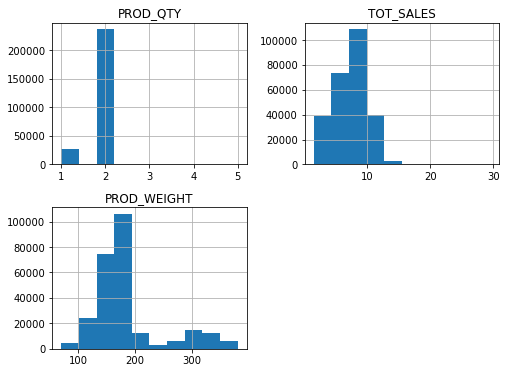

In [19]:
#Check the distribution of the Product quantity and total sales.
merged.hist(figsize=(8,6));

In [20]:
#now let's see the catrgory variables 
print("LIFESTAGE:\n",merged.LIFESTAGE.value_counts())
print("PREMIUM_CUSTOMER:\n",merged.PREMIUM_CUSTOMER.value_counts())

LIFESTAGE:
 OLDER SINGLES/COUPLES     54478
RETIREES                  49763
OLDER FAMILIES            48594
YOUNG FAMILIES            43592
YOUNG SINGLES/COUPLES     36377
MIDAGE SINGLES/COUPLES    25110
NEW FAMILIES               6919
Name: LIFESTAGE, dtype: int64
PREMIUM_CUSTOMER:
 Mainstream    101988
Budget         93157
Premium        69688
Name: PREMIUM_CUSTOMER, dtype: int64


In [21]:
#Since we only interest on the chips we need to extract the chip products
merged['PROD_NAME'].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'Red Rock Deli Chikn&Garlic Aioli 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Natural ChipCo      Hony Soy Chckn175g',
       'WW Original Stacked Chips 160g', 'Cheetos Puffs 165g',
       'Infuzions SourCream&Herbs Veg Strws 110g',
       'RRD SR Slow Rst     Pork Belly 150g',
       'Doritos Cheese      Supreme 330g', 'Doritos Mexicana    170g',
       'Old El Paso Salsa   Dip Tomato Med 300g',
       'GrnWves Plus Btroot & Chilli Jam 180g',
       'Smiths Crinkle Cut  Chips Barbecue 170g',
       'Kettle Sensations   Camembert & Fig 150g',
       'Doritos Corn Chip Southern Chicken 150g',
       'CCs Tasty Cheese    175g', 'Tostitos Splash Of  Lime 175g',
       'Kettle 135g Swt Pot Sea Salt', 'RRD Salt & Vinegar  165g',
       'Infuzions Mango     Chutny Papadums 70g',
       'Smiths Crinkle Cut  Snag&Sauce 150g',
       'Smiths Crinkle      Original 330g',
       'RRD Sweet Chilli &  Sour Cream 165g',
     

In [22]:
#Drop rows with salsa word and removing special characters.
merged['PROD_NAME']=merged['PROD_NAME'].str.replace('(\d+g)|(&)',"")
merged=merged[~merged['PROD_NAME'].str.contains(('Salsa|salsa'),regex=True)]
merged.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGHT
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt,2,6.0,175.0
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli ChiknGarlic Aioli,1,2.7,175.0
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour CreamChives 210G,1,3.6,170.0
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn,1,3.0,175.0
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips,1,1.9,150.0


In [23]:
# Extract brand name from PROD_NAME and create new column called BRAND
part = transaction['PROD_NAME'].str.partition()
merged['BRAND'] = part[0]
merged.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WEIGHT,BRAND
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt,2,6.0,175.0,Natural
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli ChiknGarlic Aioli,1,2.7,175.0,CCs
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour CreamChives 210G,1,3.6,170.0,Smiths
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn,1,3.0,175.0,Smiths
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips,1,1.9,150.0,Kettle


In [24]:
merged['BRAND'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grain', 'Doritos',
       'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns', 'Red',
       'Pringles', 'Dorito', 'Twisties', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Woolworths', 'Cobs', 'French', 'RRD', 'Tostitos',
       'Snbts', 'Cheetos', 'Sunbites'], dtype=object)

In [25]:
#Rename brand names
merged['BRAND'].replace('NCC', 'Natural', inplace = True)
merged['BRAND'].replace('CCs', 'CCS', inplace = True)
merged['BRAND'].replace('Smith', 'Smiths', inplace = True)
merged['BRAND'].replace(['Grain', 'GrnWves'], 'Grainwaves', inplace = True)
merged['BRAND'].replace('Dorito', 'Doritos', inplace = True)
merged['BRAND'].replace('WW', 'Woolworths', inplace = True)
merged['BRAND'].replace('Infzns', 'Infuzions', inplace = True)
merged['BRAND'].replace(['Red','RRD'] ,'Red Rock Deli', inplace = True)
merged['BRAND'].replace('Snbts', 'Sunbites', inplace = True)
merged['BRAND'].unique()

array(['Natural', 'CCS', 'Smiths', 'Kettle', 'Old', 'Grainwaves',
       'Doritos', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Twisties', 'Tyrrells',
       'Cobs', 'French', 'Tostitos', 'Sunbites', 'Cheetos'], dtype=object)

In [26]:
#Finding the unique value in the transaction data
print("The unique data:\n",merged.nunique(),"\n")
#See which value are present in particular column
print("Product_quantity:\n",merged['PROD_QTY'].value_counts(),"\n")
print("DATE:\n",merged['DATE'].value_counts(),"\n")
print("Brand:\n",merged['BRAND'].value_counts(),"\n")
print("Product_weight:\n",merged['PROD_WEIGHT'].value_counts(),"\n")

The unique data:
 LYLTY_CARD_NBR       71287
LIFESTAGE                7
PREMIUM_CUSTOMER         3
DATE                   364
STORE_NBR              271
TXN_ID              245255
PROD_NBR               105
PROD_NAME              105
PROD_QTY                 5
TOT_SALES              104
PROD_WEIGHT             21
BRAND                   21
dtype: int64 

Product_quantity:
 2    220069
1     25476
5       415
3       408
4       371
Name: PROD_QTY, dtype: int64 

DATE:
 2018-12-24    879
2018-12-23    858
2018-12-22    848
2018-12-19    837
2018-12-20    803
             ... 
2018-12-12    615
2018-09-22    615
2019-06-24    612
2019-06-13    611
2018-11-25    600
Name: DATE, Length: 364, dtype: int64 

Brand:
 Kettle           38433
Smiths           29666
Doritos          26216
Pringles         23419
Red Rock Deli    16551
Woolworths       13724
Infuzions        13253
Thins            13125
Cobs              9038
Tostitos          8825
Twisties          8789
Old               8703
Grai

In [27]:
#As we can see, the date column only has 364 unique values, using the method to see which day is the missing date
import datetime
pd.date_range(start=merged["DATE"].min(), end=merged["DATE"].max()).difference(merged["DATE"])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

We can see that the missing day is 2018-12-25, which is Christmas.

In [28]:
# Create a new dataframe which contains the total sale for each date
date_total_1= pd.pivot_table(merged, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
date_total_1.shape

(364, 1)

In [29]:
date_total_2=pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
date_total_2['TOT_SALES'] =0
date_total = date_total_1+date_total_2
date_total.fillna(0, inplace = True)
date_total.index.name = 'Date'
date_total.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
date_total.shape

(365, 1)

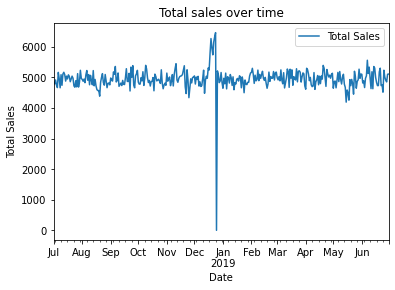

In [30]:
# See the total sales over the year
date_total.plot(kind='line',figsize=(6,4))
plt.title('Total sales over time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

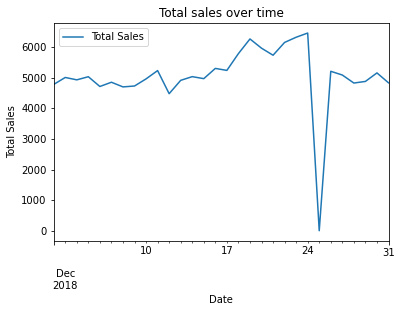

In [31]:
#See the December total sales
Dec_date_total = date_total[(date_total.index > "2018-12-1") & (date_total.index < "2019-1-1")]
Dec_date_total.plot(kind='line',figsize=(6,4))
plt.title('Total sales over time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()


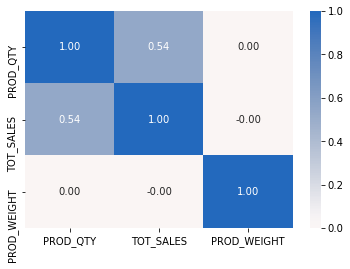

In [32]:
#See the correlation between the numeric variables
sns.heatmap(merged.corr(),annot=True,fmt='.2f',cmap='vlag_r',center=0);

<Figure size 720x576 with 0 Axes>

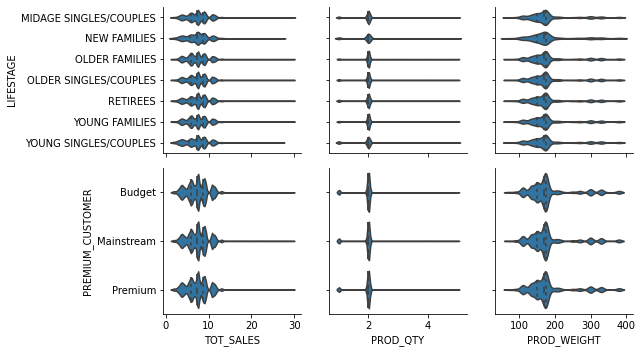

In [47]:
#Check the relationship of different categorical variable with total sales
base_color=sns.color_palette()[0]
plt.figure(figsize=(10,8))
g=sns.PairGrid(data=merged,x_vars=['TOT_SALES','PROD_QTY','PROD_WEIGHT'],
             y_vars=['LIFESTAGE','PREMIUM_CUSTOMER']);
g.map(sns.violinplot,inner='quartile',color=base_color);

It is obvious that the product quantity has positive relationship with total sales, but the product weight seems no relationship woth product quantity and total sales.

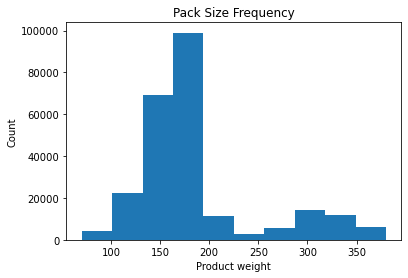

In [48]:
#Most frequently purchased product weight 
plt.figure(figsize = (6,4))
plt.hist(merged['PROD_WEIGHT'])     
plt.xlabel('Product weight')
plt.ylabel('Count')
plt.title('Pack Size Frequency');

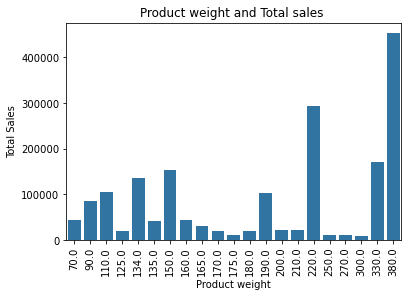

In [57]:
#Which packet size producing highest total sales
plt.figure(figsize=(6,4))
plt.title("Product weight and Total sales ")
plt.xticks(rotation=90)
sns.barplot(data=merged,y=merged.groupby("PROD_WEIGHT").TOT_SALES.sum(), x=merged.PROD_WEIGHT.unique(),color=base_color)
plt.ylabel('Total Sales')
plt.xlabel('Product weight');

As we can see that the most count of packsize is between 150~200, but the highiest total sale is the packsize of 380.Maybe the packsize of the 380g chips have higher price.  

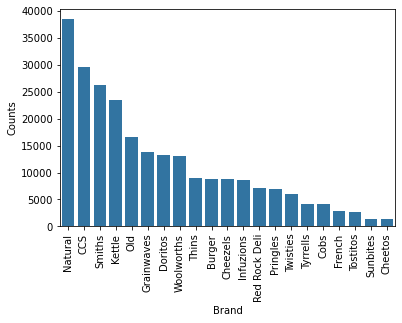

In [58]:
# Most frequently purchased brand name
plt.figure(figsize=(6,4))
plt.xticks(rotation=90) 
sns.barplot(y=merged.BRAND.value_counts(),x=merged.BRAND.unique(),color=base_color);
plt.xlabel("Brand")
plt.ylabel("Counts");

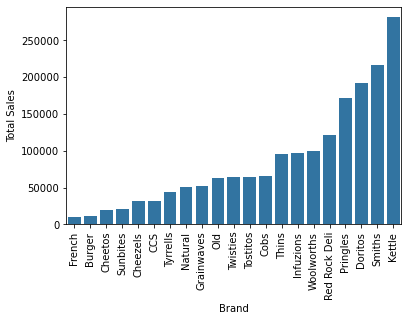

In [59]:
# Brand producing highest total sales
plt.figure(figsize=(6,4))
plt.xticks(rotation=90) 
tot=merged.groupby('BRAND',as_index=False)['TOT_SALES'].sum().sort_values(by=['TOT_SALES'])
sns.barplot(data=tot,y='TOT_SALES',x='BRAND',color=base_color,);
plt.xlabel("Brand")
plt.ylabel("Total Sales");

The most counts brand is natural but the highest total sales brand is Kette. 

In [38]:
life_sales=merged.groupby(['LIFESTAGE'],as_index=False)["TOT_SALES"].sum().sort_values(by=['TOT_SALES'])
life_sales=life_sales.reset_index(drop=True)
life_sales

,LIFESTAGE,TOT_SALES
0,NEW FAMILIES,47347.95
1,MIDAGE SINGLES/COUPLES,172523.80
2,YOUNG SINGLES/COUPLES,243756.60
3,YOUNG FAMILIES,294627.90
4,OLDER FAMILIES,328519.90
5,RETIREES,342381.90
6,OLDER SINGLES/COUPLES,376013.65


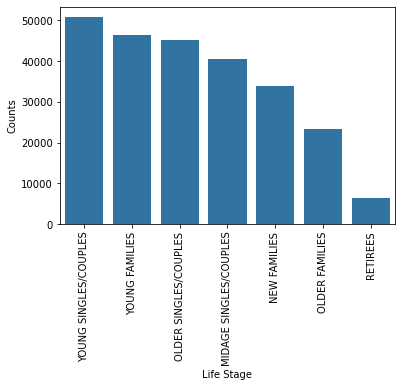

In [60]:
plt.figure(figsize=(6,4))
plt.xticks(rotation=90) 
sns.barplot(y=merged.LIFESTAGE.value_counts(),x=merged.LIFESTAGE.unique(),color=base_color);
plt.xlabel("Life Stage")
plt.ylabel("Counts");


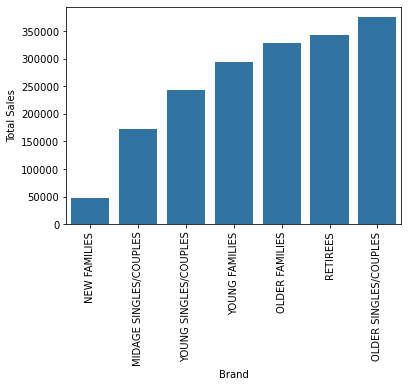

In [61]:
plt.figure(figsize=(6,4))
plt.xticks(rotation=90) 
order=['NEW FAMILIES','MIDAGE SINGLES/COUPLES','YOUNG SINGLES/COUPLES','YOUNG FAMILIES','OLDER FAMILIES','RETIREES','OLDER SINGLES/COUPLES']
sns.barplot(data=life_sales,y='TOT_SALES',x='LIFESTAGE',color=base_color,order=order);
plt.xlabel("Brand")
plt.ylabel("Total Sales");



In [41]:
pre_sales=merged.groupby(['PREMIUM_CUSTOMER'],as_index=False)["TOT_SALES"].sum().sort_values(by=['TOT_SALES'])
pre_sales=pre_sales.reset_index(drop=True)
pre_sales.head()

,PREMIUM_CUSTOMER,TOT_SALES
0,Premium,472899.45
1,Budget,631406.85
2,Mainstream,700865.40


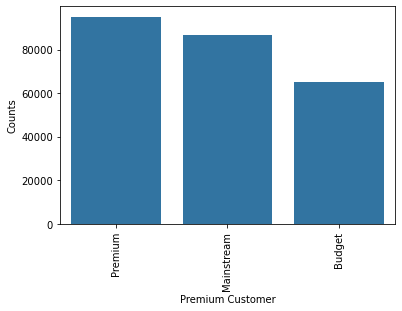

In [62]:
plt.figure(figsize=(6,4))
plt.xticks(rotation=90) 
sns.barplot(y=merged.PREMIUM_CUSTOMER.value_counts(),x=merged.PREMIUM_CUSTOMER.unique(),color=base_color);
plt.xlabel("Premium Customer")
plt.ylabel("Counts");

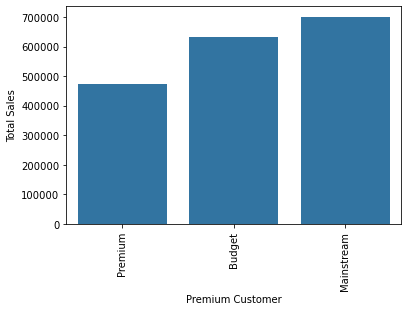

In [63]:
plt.figure(figsize=(6,4))
plt.xticks(rotation=90) 
order=['Premium','Budget','Mainstream']
sns.barplot(data=pre_sales,y='TOT_SALES',x='PREMIUM_CUSTOMER',color=base_color,order=order);
plt.xlabel("Premium Customer")
plt.ylabel("Total Sales");

In [44]:
avg_unit=pd.DataFrame(merged.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PROD_QTY"].sum() / merged.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["LYLTY_CARD_NBR"].nunique())
avg_price=pd.DataFrame(merged.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].sum() / merged.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["PROD_QTY"].sum())

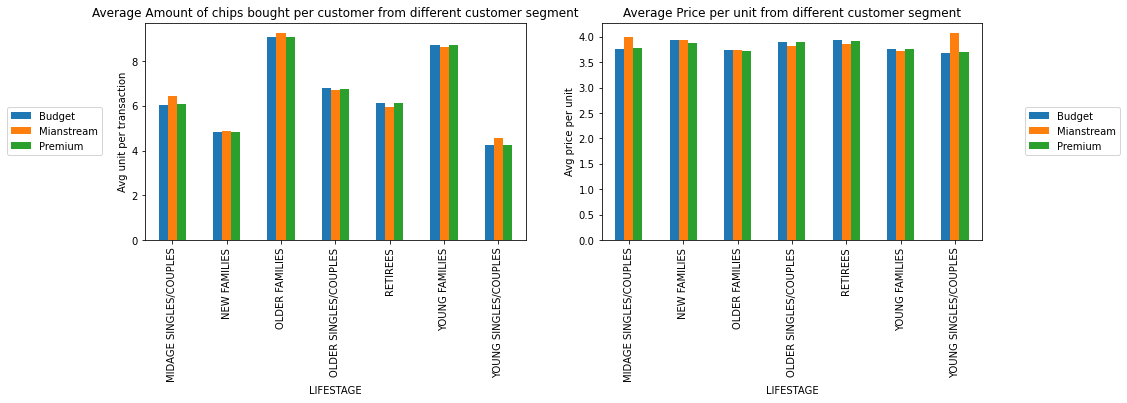

In [64]:
# subplot 1: Avg unit per transaction of different customer segment
fig, ax = plt.subplots(ncols = 2, figsize = [10,8])
avg_unit.unstack().plot.bar(figsize=(15,4),rot=0, ax = ax[0])
plt.setp(ax[0].get_xticklabels(),rotation=90)
ax[0].legend(["Budget","Mianstream","Premium"],loc="center right", bbox_to_anchor=(-0.1,0.5))
ax[0].set_title('Average Amount of chips bought per customer from different customer segment')
ax[0].set_ylabel('Avg unit per transaction')
# subplot 2: Avg price per unit of different customer segment
avg_price.unstack().plot.bar(figsize=(15,4), rot=0, ax = ax[1])
plt.setp(ax[1].get_xticklabels(),rotation=90)
ax[1].legend(["Budget","Mianstream","Premium"],loc="center left", bbox_to_anchor=(1.1,0.5));
ax[1].set_title('Average Price per unit from different customer segment')
ax[1].set_ylabel('Avg price per unit');

Since our insights should have a commercial applicatipon,I decided to analysis the total sale as the main metric.

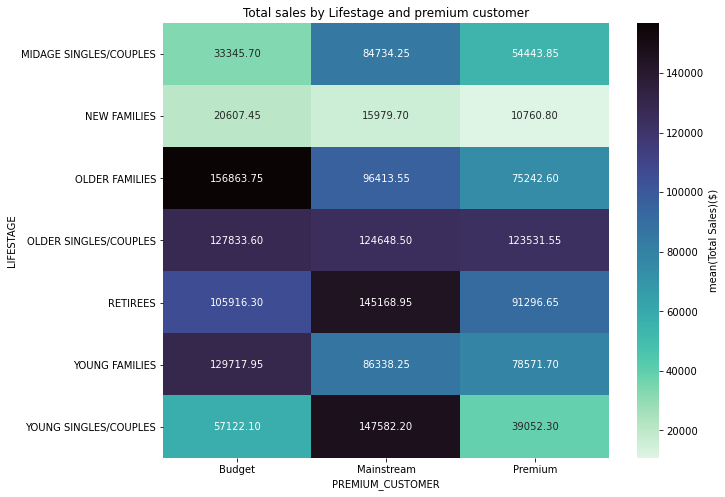

In [46]:
LP_means=merged.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).sum()['TOT_SALES']
LP_means=LP_means.reset_index(name="TOT_SALES")
LP_means=LP_means.pivot(index='LIFESTAGE',columns='PREMIUM_CUSTOMER',values='TOT_SALES')
plt.figure(figsize = [10,8])
plt.title('Total sales by Lifestage and premium customer');
sns.heatmap(LP_means,annot=True,fmt='.2f',cbar_kws={'label':'mean(Total Sales)($)'},cmap="mako_r",);

Conclusion:
The Kettle brand has highest total sales , but the natural is the most frequently purchased brand.
The most frequently purcahse product weight around 135-175, but product weight with 380 has highest total sales.
The Older Families with budget ,young singles/couples and Retirees with Mainstream has highest total sales.
